* Discussions - 
    * check feasibility of a model trained once and able to predict (like train every 7 days). If not - we can train everyday. 
    * Intent of predicting topics is it to show say pvs last week for a topic vs this week. How far out such comparisons need to be made? -- that will decide the date range of training and prediction -- a week is good strat
    * Keep topic words same but test with lesser number of words
    * Not every article needs to be assigned to a topic. so noise part of hdbscan is fine

**Data product options:**

* Technique 1 - train every 7 days
    * PART 1: Check if day-of-week = Monday :: 
        * Take past 7 days (apr 26 till may 02)
        * Train & store file
        * Get yesterday's topics (may 02) and save that 1 day
        
    * PART 2: Else ::
        * Take yesterday's eligible articles
        * Use the saved cluster file and predict
        * save that 1 day
        * Part 2 will be repeated from tues till sunday of a week
        
    * When loop progresses to day = Monday, execute Part 1, then Part 2 and loop goes on 
    
Note: 
* Caveat - We are training on articles which already have labels (through prediction).   
* Save embeddings - so repeating ones need not be calculated. Plus, they can be used as features in other projects

**Environment issue**:
* On 6/11/2021 upgrading transformers messed up the environment (topics). Recreated using req.txt (called topics-env).
* Imp point to note - for umap, hdbcsan to work, numba>-0.50.x Added this to the req.txt
* transformers library version = 4.3.2 -- add this during deployment if going with topic summarization
* Not deleting topics environment, in case other working library versions need to be consulted 

**Environment issue -2**:
* On 7/8/2021 importing hdbscan library started giving weird error - "hdbscan ValueError: numpy.ndarray size changed, may indicate binary incompatibility. Expected 88 from C header, got 80 from PyObject". [Link](https://github.com/scikit-learn-contrib/hdbscan/issues/457) indicated some issue to do with numpy and scipy upgrades. So, added scipy to req.txt with version. Also upgraded all libraries to latest pypi installations and created env "topic-env-latest". Final working req-mod.txt has following libraries:<br>
<br>
pandas==1.2.3<br>
numpy==1.21.0<br>
scipy ==1.7.0<br>
joblib==1.0.1<br>
hdbscan==0.8.27 <br>
umap-learn==0.5.1<br>
sentence-transformers==2.0.0<br>
numba==0.53.1<br>
nltk==3.6.2<br>
matplotlib==3.4.2 <br>
seaborn==0.11.1 <br>
pyarrow==4.0.1 <br>
google-cloud-bigquery==2.20.0<br>
google-cloud-storage==1.40.0<br>

In [1]:
""" Helper imports"""
import re
import joblib
import pandas as pd
import numpy as np
from time import time
from nltk.tokenize import sent_tokenize
from joblib import Parallel, delayed
from sklearn.metrics.pairwise import cosine_similarity

"""Modeling imports"""
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# from gensim.models.coherencemodel import CoherenceModel
# from gensim.corpora.dictionary import Dictionary
# from gensim.models.nmf import Nmf

""" Plotting imports"""
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

# remove this later
pd.set_option('max_colwidth', 110)
import warnings
warnings.filterwarnings('ignore')

### Competitor research:
* WSJ uses HDBSCAN - https://medium.com/the-wall-street-journal/staying-on-topic-building-an-automated-topic-model-of-wsj-news-coverage-d4dc4369f71b

In [3]:
from src.util import (c_tf_idf, 
                      extract_top_n_words_per_topic,
                      extract_topic_sizes,
                      topic_cos_sim_metrics,
                      generate_all_cossim_metrics)

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.97k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/450 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [4]:
import umap
import hdbscan
from sentence_transformers import SentenceTransformer
from hdbscan import validity_index

In [5]:
data_path = '/home/jupyter/bi-topic-modeling/data/' 

STOP_WORDS = pd.read_pickle(data_path + 'forbes_stop_words.pkl')
"q1" in STOP_WORDS

True

In [6]:
results_path = '/home/jupyter/bi-topic-modeling/results/' 
SEED = 42

### --- Data ---

* Train date range Apr 19 (monday) till May 02 (sunday)
* Eligible pool = articles with pvs > 100 on a given day
    * TODO: data points to prove my point - check common articles in apr 19-apr24 week with consecutive 2 weeks
    * manual analysis of training topics

In [7]:
def get_data(file_name):
    
    df = pd.read_csv(data_path + file_name)

    print("Before Shape:", df.shape)
    print("Unique tiers:", len(df.tier1.unique()))
    
    # Per verdict from EDA, exclude articles less than 100 words
    df["article_length"] = df.clean_body.str.split().apply(len)
    df = df[df["article_length"]>=100]
    print("After Shape:", df.shape)
    
    df.tier1 = df.tier1.fillna('Other')
    df = df.reset_index(drop=True)
    
    return df

In [8]:
print("--- apr 19 to apr 24 ---")
apr19_apr24 = get_data('processed/apr19_apr24_over100pvs_processed.csv')
apr19_apr24_art_embed = joblib.load("./data/processed/apr19_apr24_article_embed_axis0.joblib")
print("Embeds len:", len(apr19_apr24_art_embed))

--- apr 19 to apr 24 ---
Before Shape: (7193, 10)
Unique tiers: 31
After Shape: (7179, 11)
Embeds len: 7179


In [9]:
# training data set

print("--- apr 25 ---")
apr25 = get_data('processed/train_apr25_over100pvs_processed.csv')
apr25_art_embed = joblib.load("./data/processed/apr25_article_embed_axis0.joblib")
print("Embeds len:", len(apr25_art_embed))

print()
print("--- apr 26 ---")
apr26 = get_data('processed/pred_apr26_over100pvs_processed.csv')
apr26_art_embed = joblib.load("./data/processed/apr26_article_embed_axis0.joblib")
print("Embeds len:", len(apr26_art_embed))

print()
print("--- apr 27 ---")
apr27 = get_data('processed/pred_apr27_over100pvs_processed.csv')
apr27_art_embed = joblib.load("./data/processed/apr27_article_embed_axis0.joblib")
print("Embeds len:", len(apr27_art_embed))

print()
print("--- apr 28 ---")
apr28 = get_data('processed/apr28_over100pvs_processed.csv')
apr28_art_embed = joblib.load("./data/processed/apr28_article_embed_axis0.joblib")
print("Embeds len:", len(apr28_art_embed))

print()
print("--- apr 29 ---")
apr29 = get_data('processed/apr29_over100pvs_processed.csv')
apr29_art_embed = joblib.load("./data/processed/apr29_article_embed_axis0.joblib")
print("Embeds len:", len(apr29_art_embed))

print()
print("--- apr 30 ---")
apr30 = get_data('processed/apr30_over100pvs_processed.csv')
apr30_art_embed = joblib.load("./data/processed/apr30_article_embed_axis0.joblib")
print("Embeds len:", len(apr30_art_embed))

print("--- may 01 ---")
may01 = get_data('processed/may01_over100pvs_processed.csv')
may01_art_embed = joblib.load("./data/processed/may01_article_embed_axis0.joblib")
print("Embeds len:", len(may01_art_embed))

print()
print("--- may 02 ---")
may02 = get_data('processed/may02_over100pvs_processed.csv')
may02_art_embed = joblib.load("./data/processed/may02_article_embed_axis0.joblib")
print("Embeds len:", len(may02_art_embed))

--- apr 25 ---
Before Shape: (3334, 10)
Unique tiers: 31
After Shape: (3327, 11)
Embeds len: 3327

--- apr 26 ---
Before Shape: (4138, 10)
Unique tiers: 31
After Shape: (4128, 11)
Embeds len: 4128

--- apr 27 ---
Before Shape: (4177, 10)
Unique tiers: 31
After Shape: (4167, 11)
Embeds len: 4167

--- apr 28 ---
Before Shape: (4197, 8)
Unique tiers: 31
After Shape: (4186, 9)
Embeds len: 4186

--- apr 29 ---
Before Shape: (4201, 8)
Unique tiers: 31
After Shape: (4188, 9)
Embeds len: 4188

--- apr 30 ---
Before Shape: (3784, 8)
Unique tiers: 31
After Shape: (3771, 9)
Embeds len: 3771
--- may 01 ---
Before Shape: (3052, 8)
Unique tiers: 31
After Shape: (3044, 9)
Embeds len: 3044

--- may 02 ---
Before Shape: (3267, 8)
Unique tiers: 31
After Shape: (3259, 9)
Embeds len: 3259


In [10]:
# testing data set

print()
print("--- may 03 ---")
may03 = get_data('processed/may03_over100pvs_processed.csv')
may03_art_embed = joblib.load("./data/processed/may03_article_embed_axis0.joblib")
print("Embeds len:", len(may03_art_embed))

print()
print("--- may 04 ---")
may04 = get_data('processed/may04_over100pvs_processed.csv')
may04_art_embed = joblib.load("./data/processed/may04_article_embed_axis0.joblib")
print("Embeds len:", len(may04_art_embed))

print()
print("--- may 05 ---")
may05 = get_data('processed/may05_over100pvs_processed.csv')
may05_art_embed = joblib.load("./data/processed/may05_article_embed_axis0.joblib")
print("Embeds len:", len(may05_art_embed))

print("--- may 06 ---")
may06 = get_data('processed/may06_over100pvs_processed.csv')
may06_art_embed = joblib.load("./data/processed/may06_article_embed_axis0.joblib")
print("Embeds len:", len(may06_art_embed))

print("--- may 07 ---")
may07 = get_data('processed/may07_over100pvs_processed.csv')
may07_art_embed = joblib.load("./data/processed/may07_article_embed_axis0.joblib")
print("Embeds len:", len(may07_art_embed))


--- may 03 ---
Before Shape: (4210, 8)
Unique tiers: 31
After Shape: (4199, 9)
Embeds len: 4199

--- may 04 ---
Before Shape: (4235, 8)
Unique tiers: 31
After Shape: (4223, 9)
Embeds len: 4223

--- may 05 ---
Before Shape: (4174, 8)
Unique tiers: 31
After Shape: (4160, 9)
Embeds len: 4160
--- may 06 ---
Before Shape: (4079, 8)
Unique tiers: 31
After Shape: (4063, 9)
Embeds len: 4063
--- may 07 ---
Before Shape: (3644, 8)
Unique tiers: 31
After Shape: (3630, 9)
Embeds len: 3630


* Combine train data - 14 days: apr 19 (monday) till may 2 (sunday)
* Observation:
    * 1 week apr 19 - apr 24 :: 7179 unique articles
    * 2 week apr 19 - may 02 :: 10225 unique articles (i.e. 2nd week just 3k unique articles added)

In [11]:
# concatenate dfs

combined_df = pd.concat([apr19_apr24, apr25, apr26, apr27, apr28, apr29, apr30, may01, may02])
# reset index
combined_df = combined_df.reset_index(drop=True)
# drop unnecessary cols
combined_df.drop(["processed", "processed_noun", "processed_noun_2"], axis = 1, inplace=True)
# fill na
combined_df.tier2 = combined_df.tier2.fillna('Other')
combined_df.total_timeonpage = combined_df.total_timeonpage.fillna(0)
print(combined_df.shape)

# concatenate embeds
combined_embeds = apr19_apr24_art_embed + apr25_art_embed + apr26_art_embed + apr27_art_embed + apr28_art_embed + apr29_art_embed + apr30_art_embed + may01_art_embed + may02_art_embed
print(len(combined_embeds))

(37249, 11)
37249


In [12]:
# drop duplicates from df

train_df = combined_df.drop_duplicates(subset="content_natid", keep='first')

print(train_df.shape)
print(train_df.content_natid.duplicated(keep='first').any())

train_embeds =  [combined_embeds[i] for i in list(train_df.index)]
print(len(train_embeds))

(10225, 11)
False
10225


In [13]:
train_df.reset_index(drop=True, inplace=True)

train_df = train_df[['content_natid', 'clean_body']]
train_df.shape

(10225, 2)

* **Two weeks: Apr19-May2**

In [14]:
train_df.tail()

,content_natid,clean_body
10220,blogandpostid/blog/post/1483-2567,"2015 polaris slingshot: three wheels and a prayer. polaris, the powersports giant, moves from off-road, sn..."
10221,blogandpostid/blog/post/1763-1881,"5 critical steps to fearless confrontation. last week, i had the pleasure of presenting a webinar called s..."
10222,blogandpostid/blog/post/986-8269,"the oilman, the playmate, and the tangled affairs of the billionaire marshall family. j. howard marshall i..."
10223,blogandpostid/blog/post/948-4920,hacker's demo shows how easily credit cards can be read through clothes and wallets. some blank credit car...
10224,blogandpostid/blog/post/1011-2227,man inadvertently live tweets osama bin laden raid. an it consultant who tried to take a break from the ra...


### --- Modeling ---

In [15]:
data = train_df.clean_body.tolist()
print(len(data))

10225


In [16]:
# NEW SETTINGS for lesser noise - umap:n_neighbors=15, n_components=2, min_dist=0.0 
# hdbscan min_cluster_size=5, min_samples = 4, input = sentence embeddings aggregated (mean) to full article

start = time()

# orig
# n_neighbors=15, n_components=5, random_state=SEED,
            
umap_embeddings =  umap.UMAP(
                             n_neighbors=15,
                             min_dist=0.0,
                             n_components=2,
                             random_state=SEED
                            ).fit(train_embeds) 

print('UMAP Took {} minutes to run'.format(round((time() - start) / 60, 2))) #4.06

UMAP Took 0.4 minutes to run


In [17]:
# cluster
cluster = hdbscan.HDBSCAN(min_cluster_size=5,
                      min_samples = 4, #new
                      metric= 'euclidean',                      
                      cluster_selection_method='eom',
                      prediction_data=True).fit(umap_embeddings.embedding_)

In [18]:
print("Shape of training embeddings:", umap_embeddings.embedding_.shape)

Shape of training embeddings: (10225, 2)


In [19]:
labels = cluster.labels_
print("Settings - mean axis=0")
validity_index(umap_embeddings.embedding_.astype('double'), labels)

Settings - mean axis=0


0.24814128539871702

In [20]:
# put topics in dataframe
docs_df = pd.DataFrame(data, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))

print("Distinct topics including -1 for noise", len(docs_df.Topic.unique()))
print()
docs_df
# min samples5 =  298 topics

Distinct topics including -1 for noise 386



,Doc,Topic,Doc_ID
0,10 top-rated air fryers that make cooking so much easier. if an appliance could deliver the delicious cris...,68,0
1,"10 highly-rated mattresses on amazon (yes, theyre eligible for prime shipping). if youve begun to second-g...",80,1
2,"11 adirondack chairs that will become your favorite place to sit this summer. adirondack chairs, which get...",80,2
3,"the best home printers in 2021 for every printing need, from tax forms to family portraits. as much as wed...",76,3
4,"the best sales online right now: tatcha, best buy and more. summer doesnt officially start until june 20bu...",79,4
...,...,...,...
10220,"2015 polaris slingshot: three wheels and a prayer. polaris, the powersports giant, moves from off-road, sn...",27,10220
10221,"5 critical steps to fearless confrontation. last week, i had the pleasure of presenting a webinar called s...",-1,10221
10222,"the oilman, the playmate, and the tangled affairs of the billionaire marshall family. j. howard marshall i...",-1,10222
10223,hacker's demo shows how easily credit cards can be read through clothes and wallets. some blank credit car...,51,10223


In [21]:
start = time()

# combine together all articles belonging to same cluster  
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

# calculate countVector and tf-idf
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

# top n words, topic size
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); 

# modify top_n_words per topic dict into dataframe for presentation
topic_words_dict = {}  

for k, v in top_n_words.items():
    topic_words_dict[k] = ", ".join([elem[0] for elem in v])

pd.set_option("max_colwidth", 250)
top_n_words_df = pd.DataFrame.from_dict(topic_words_dict, 
                                        orient='index').reset_index().rename(columns={'index':'topic_num',
                                                                                      
                                                                                      0:'topic_words'}) 

print('Took {} minutes to run'.format(round((time() - start) / 60, 2)))

Took 1.51 minutes to run


In [22]:
# clean keywords

from collections import OrderedDict
# from fuzzywuzzy import process, fuzz
from itertools import chain

import time
start = time.time()

clean_keys = []
for index, row in top_n_words_df.iterrows(): 
    
    # remove STOP WORDS and remove whitespaces
    inter_list = [x.strip() for x in row["topic_words"].split(",") if x not in STOP_WORDS]
    
    # remove numbers but not alphanumerics e.g. remove 400, not ps4 
    inter_list = [x for x in inter_list if not x.isnumeric()]
    
    # remove subset-based similar words - e.g. 'pcr tests' and 'tests' then 'tests' will be removed
    inter_list = [i for i in inter_list if not any(i in x and i!=x for x in inter_list)]

    # remove empty or 1-letter words
    inter_list = [x for x in inter_list if len(x)>1]
    
    # de-duplicate
    inter_list = list(OrderedDict.fromkeys(inter_list))
    
    # keep top 20 cleaned keywords
    inter_list = inter_list[:6] 
    
    # convert into string
    inter_list = ', '.join(inter_list)
    
    clean_keys.append(inter_list)

end = time.time()
print("keyword time", (end - start)/60) 

keyword time 0.0006589333216349284


In [23]:
top_n_words_df["topic_words"] = clean_keys

In [24]:
# GENERATE TOPIC METRICS

# per topic - cos_min and cos_mean
train_cossim_df = generate_all_cossim_metrics(docs_df, train_embeds)

# # per topic - tier counts
# tier_metric = docs_df.join(df[["tier1"]])

# iab_metric = tier_metric.groupby("Topic").agg({"tier1": 
#                                                'nunique'}).round(2).reset_index().rename(columns = {'tier1': 
#                                                                                                     'distinct_tier1s',
#                                                                                                     'Topic':
#                                                                                                     'topic_num'})

# combine topic, top words, cos and tier metrics
topic_info = pd.merge(pd.merge(top_n_words_df, 
                               topic_sizes, how="inner", left_on="topic_num", right_on = "Topic"), 
                               train_cossim_df, on = "topic_num", how="inner")

topic_info.drop('Topic', axis=1, inplace=True)

In [25]:
topic_info.head()

,topic_num,topic_words,Size,cos_min,cos_mean
0,-1,"energy, marketing, climate, customer, human, industry",3171,0.06,0.71
1,0,"trading days, average return, trefis machine, p500, learning engine, 21 trading",22,0.88,0.96
2,1,"taylors version, billboard 200, hot 100, bts, swift, fearless taylors",104,0.39,0.84
3,2,"10 states, average annual, annual wage, salaries, occupational, therapist salary",46,0.43,0.86
4,3,"def, nxt, smackdown, roman reigns, aew, live events",13,0.75,0.88


* Observation on cluter-goodness:
    * Good quality overall - 
        * most articles in a group on avg have 0.85-0.93 cosine similarity which is pretty high
        * min similarity is also 0.7 and above for most topics
        
    * Manual eyeballing - 88 topics good, 19 bad

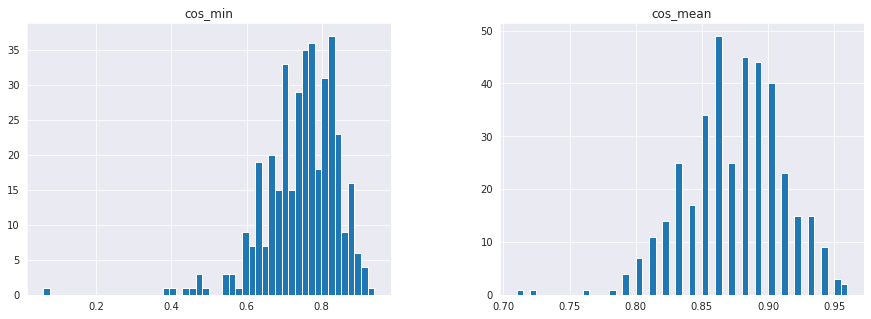

In [25]:
# TEST FOR LESSER NOISE - 2 weeks - 6.28.21 with min_samples=4
topic_info[['cos_min', 'cos_mean']].hist(figsize= (15,5), bins=50)
plt.show()

**Topics are about:**


In [26]:
# combine natural id inside docs_df
docs_df = pd.merge(docs_df, train_df, how="left", left_on="Doc", right_on="clean_body")
docs_df.drop("clean_body", axis=1, inplace=True)

In [27]:
# contains natid, article body, assigned topic

full_train_topics = pd.merge(docs_df, topic_info, how="left", left_on="Topic", right_on="topic_num")
full_train_topics.head(1)

,Doc,Topic,Doc_ID,content_natid,topic_num,topic_words,Size,cos_min,cos_mean
0,"10 top-rated air fryers that make cooking so much easier. if an appliance could deliver the delicious crispy taste of fried food without all that unhealthy oil, would you buy it? if you answered with an enthusiastic yes, youre not alone. air frye...",68,0,blogandpostid/blog/post/4983-5e9d2e095429aa00076f4970,68,"hair, shampoo, dry, filter, oil, skincare",122,0.54,0.81


In [28]:
# with min_sample5= 3257

# with min_samples=4
full_train_topics[full_train_topics.Topic==-1].shape

(3171, 9)

* **Predict new points/articles - May 3**
    * worsened. orig may 3 topics = 260, with 2weeks = 251

In [29]:
print(umap_embeddings)
print()
print(cluster)

UMAP(dens_frac=0.0, dens_lambda=0.0, min_dist=0.0, random_state=42)

HDBSCAN(min_samples=4, prediction_data=True)


**Note:** 
* There will be articles read between Apr 26 - May 02 (training set), which will also be read on May 03. 
* These common articles present in prediction set, will get the same topic cluster as before

**For now:**
* Predict on whole of may03

In [30]:
# dimensionality reduction
umap_embeddings_may03 = umap_embeddings.transform(may03_art_embed) # min_dist=0.0,

print("Training input shape:", umap_embeddings.embedding_.shape)
print("Prediction input shape:", umap_embeddings_may03.shape) #takes a min

Training input shape: (10225, 2)
Prediction input shape: (4199, 2)


In [31]:
# predict

may03_test_labels, may03_strengths = hdbscan.approximate_predict(cluster, umap_embeddings_may03)

print(len(may03_test_labels))
print(len(set(may03_test_labels)))
# earlier - 310 topics

4199
316


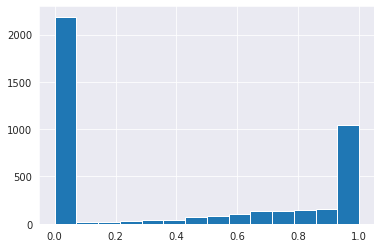

In [32]:
plt.hist(may03_strengths, bins='auto')
plt.show()

In [33]:
# put topics in dataframe
may03_docs_df = may03[['clean_body']]
may03_docs_df.rename(columns={'clean_body':'Doc'}, inplace=True)
may03_docs_df["Topic"] = may03_test_labels

print("Distinct topics including -1 for noise", len(may03_docs_df.Topic.unique()))
print()
may03_docs_df.tail()

Distinct topics including -1 for noise 316



,Doc,Topic
4194,"alexander the great: gay or straight?. (one in a series of conversations between historians james romm and paul a. cartledge , editor and introduction-author, respectively, of the new landmark arrian: the campaigns of alexander , published by pan...",-1
4195,"mark zuckerberg joins the north american man-boy love association, and other adventures in facebook groups. my colleague kashmir hill congratulated facebook's mark zuckerberg earlier today on his increasingly savvy approach to talking about priva...",51
4196,"why reits make sense. michael gunzenhaeuser, a 59-year-old semiretired obstetrician in mansfield, ohio, has heard his share of real estate horror stories lately. friends who own rental apartments grousing about plumbers' bills and endless tenant ...",-1
4197,brrr!. bill clinton recently brought up the idea that we might have to slow down the u.s. economy to cut back on greenhouse emissions in order to save the planet from global warming. less prosperity will be our salvation! putting aside the former...,-1
4198,"fact and comment. fantastic fiber future is here--but not in u.s. washington and the federal communications commission should look to south korea to see what the future could be like with true telecom deregulation. in the u.s. a t-1 line, which p...",293


In [34]:
may03_topic_sizes = extract_topic_sizes(may03_docs_df)

# GENERATE TOPIC METRICS

# per topic - cos_min and cos_mean
may03_cossim_df = generate_all_cossim_metrics(may03_docs_df, umap_embeddings_may03)

# per topic - tier counts
tier_metric = may03_docs_df.join(may03[["tier1"]])

iab_metric = tier_metric.groupby("Topic").agg({"tier1": 
                                               'nunique'}).round(2).reset_index().rename(columns = {'tier1': 
                                                                                                    'distinct_tier1s',
                                                                                                    'Topic':
                                                                                                    'topic_num'})

# combine topic, top words, cos and tier metrics
topic_info_may03 = pd.merge(pd.merge(may03_topic_sizes, 
                                        may03_cossim_df, how="inner", left_on="Topic", right_on = "topic_num"), 
                               iab_metric, on = "topic_num", how="inner")

topic_info_may03.drop('Topic', axis=1, inplace=True)

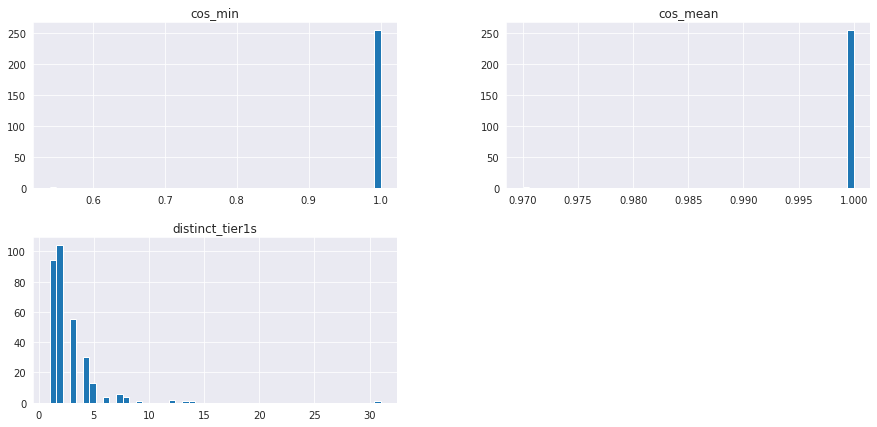

In [35]:
# TEST FOR LESSER NOISE
topic_info_may03[['cos_min', 'cos_mean', 'distinct_tier1s']].hist(figsize= (15,7), bins=50)
plt.show()

In [36]:
# combine natural id inside docs_df

may03_docs_df = pd.merge(may03_docs_df, may03, how="left", left_on="Doc", right_on="clean_body")
may03_docs_df.drop("clean_body", axis=1, inplace=True)

In [37]:
# print(len(may03_docs_df[may03_docs_df.Topic!=-1].tier1.unique()))
# may03_docs_df[may03_docs_df.Topic!=-1].tier1.value_counts()

In [38]:
# combine topic_info_may03 with topic names

topic_info_may03 = pd.merge(topic_info_may03, top_n_words_df, how="left", on="topic_num").sort_values("topic_num")

In [39]:
pred_may03_inspect = pd.merge(may03_docs_df, 
         topic_info_may03, 
         how="left", 
         left_on="Topic", 
         right_on = "topic_num").drop('topic_num', axis=1)

In [40]:
# increased to 50% noise
print(pred_may03_inspect[pred_may03_inspect.Topic==-1].shape)
print(pred_may03_inspect[pred_may03_inspect.Topic!=-1].shape)
print(pred_may03_inspect.shape)

(2179, 15)
(2020, 15)
(4199, 15)


In [41]:
# 2 WEEK TRAINING TEST FOR LESSER NOISE
pred_may03_inspect.to_csv(results_path + "14daytrain_may03pred.csv", index=False)

* **Predict new points/articles - May 04**

In [42]:
# dimensionality reduction
umap_embeddings_may04 = umap_embeddings.transform(may04_art_embed) # min_dist=0.0,

print("Training input shape:", umap_embeddings.embedding_.shape)
print("Prediction input shape:", umap_embeddings_may04.shape) #takes a min

Training input shape: (10225, 2)
Prediction input shape: (4223, 2)


In [43]:
# predict

may04_test_labels, may04_strengths = hdbscan.approximate_predict(cluster, umap_embeddings_may04)

print(len(may04_test_labels))
# print(set(may04_test_labels))
print(len(set(may04_test_labels)))

4223
326


In [44]:
# put topics in dataframe
may04_docs_df = may04[['clean_body']]
may04_docs_df.rename(columns={'clean_body':'Doc'}, inplace=True)
may04_docs_df["Topic"] = may04_test_labels

print("Distinct topics including -1 for noise", len(may04_docs_df.Topic.unique()))
print()
may04_docs_df.tail()

Distinct topics including -1 for noise 326



,Doc,Topic
4218,"alexander the great: gay or straight?. (one in a series of conversations between historians james romm and paul a. cartledge , editor and introduction-author, respectively, of the new landmark arrian: the campaigns of alexander , published by pan...",-1
4219,"how many olympic-sized swimming pools can we fill with billionaire gold?. gold has been in the spotlight for a while now. from hovering around $300 a troy ounce in the early part of the last decade, the precious metal has more than quadrupled in ...",-1
4220,"why reits make sense. michael gunzenhaeuser, a 59-year-old semiretired obstetrician in mansfield, ohio, has heard his share of real estate horror stories lately. friends who own rental apartments grousing about plumbers' bills and endless tenant ...",-1
4221,brrr!. bill clinton recently brought up the idea that we might have to slow down the u.s. economy to cut back on greenhouse emissions in order to save the planet from global warming. less prosperity will be our salvation! putting aside the former...,72
4222,"fact and comment. fantastic fiber future is here--but not in u.s. washington and the federal communications commission should look to south korea to see what the future could be like with true telecom deregulation. in the u.s. a t-1 line, which p...",293


In [45]:
may04_topic_sizes = extract_topic_sizes(may04_docs_df)

# GENERATE TOPIC METRICS

# per topic - cos_min and cos_mean
may04_cossim_df = generate_all_cossim_metrics(may04_docs_df, umap_embeddings_may04)

# per topic - tier counts
tier_metric = may04_docs_df.join(may04[["tier1"]])

iab_metric = tier_metric.groupby("Topic").agg({"tier1": 
                                               'nunique'}).round(2).reset_index().rename(columns = {'tier1': 
                                                                                                    'distinct_tier1s',
                                                                                                    'Topic':
                                                                                                    'topic_num'})

# combine topic, top words, cos and tier metrics
topic_info_may04 = pd.merge(pd.merge(may04_topic_sizes, 
                                        may04_cossim_df, how="inner", left_on="Topic", right_on = "topic_num"), 
                               iab_metric, on = "topic_num", how="inner")

topic_info_may04.drop('Topic', axis=1, inplace=True)

In [ ]:
# topic_info_may03[['cos_min', 'cos_mean', 'distinct_tier1s']].hist(figsize= (15,7))
# plt.show()

In [46]:
# combine natural id inside docs_df

may04_docs_df = pd.merge(may04_docs_df, may04, how="left", left_on="Doc", right_on="clean_body")
may04_docs_df.drop("clean_body", axis=1, inplace=True)

# combine topic_info_may04 with topic names

topic_info_may04 = pd.merge(topic_info_may04, top_n_words_df, how="left", on="topic_num").sort_values("topic_num")

In [47]:
pred_may04_inspect = pd.merge(may04_docs_df, 
         topic_info_may04, 
         how="left", 
         left_on="Topic", 
         right_on = "topic_num").drop('topic_num', axis=1)

pred_may04_inspect.head(1)

,Doc,Topic,pvs,total_timeonpage,content_natid,pub_date,title,tier1,tier2,article_length,Size,cos_min,cos_mean,distinct_tier1s,topic_words
0,"10 durable air mattresses that wont go flat on you overnight. whether youre planning on having overnight guests, camping , or just need a spot to crash temporarily while you furnish a new apartment, an air mattress is a must. but anyone whos ever...",80,214,35648,blogandpostid/blog/post/4983-603fce6d28b0df00061a762b,2021-06-08,10 Durable Air Mattresses That Won’t Go Flat On You Overnight,Home & Garden,NaN,2104,24,1.0,1.0,4,"pillow, memory foam, bed, sleepers, sheets, twin"


* **Predict new points/articles - May 05**

In [48]:
# dimensionality reduction
umap_embeddings_may05 = umap_embeddings.transform(may05_art_embed) # min_dist=0.0,

print("Training input shape:", umap_embeddings.embedding_.shape)
print("Prediction input shape:", umap_embeddings_may05.shape) #takes a min

Training input shape: (10225, 2)
Prediction input shape: (4160, 2)


In [49]:
# predict

may05_test_labels, may05_strengths = hdbscan.approximate_predict(cluster, umap_embeddings_may05)

print(len(may05_test_labels))
# print(set(may05_test_labels))
print(len(set(may05_test_labels)))

4160
320


In [50]:
# put topics in dataframe
may05_docs_df = may05[['clean_body']]
may05_docs_df.rename(columns={'clean_body':'Doc'}, inplace=True)
may05_docs_df["Topic"] = may05_test_labels

print("Distinct topics including -1 for noise", len(may05_docs_df.Topic.unique()))
print()
may05_docs_df.tail()

Distinct topics including -1 for noise 320



,Doc,Topic
4155,"alexander the great: gay or straight?. (one in a series of conversations between historians james romm and paul a. cartledge , editor and introduction-author, respectively, of the new landmark arrian: the campaigns of alexander , published by pan...",-1
4156,"mark zuckerberg joins the north american man-boy love association, and other adventures in facebook groups. my colleague kashmir hill congratulated facebook's mark zuckerberg earlier today on his increasingly savvy approach to talking about priva...",51
4157,"why reits make sense. michael gunzenhaeuser, a 59-year-old semiretired obstetrician in mansfield, ohio, has heard his share of real estate horror stories lately. friends who own rental apartments grousing about plumbers' bills and endless tenant ...",-1
4158,brrr!. bill clinton recently brought up the idea that we might have to slow down the u.s. economy to cut back on greenhouse emissions in order to save the planet from global warming. less prosperity will be our salvation! putting aside the former...,-1
4159,"fact and comment. fantastic fiber future is here--but not in u.s. washington and the federal communications commission should look to south korea to see what the future could be like with true telecom deregulation. in the u.s. a t-1 line, which p...",-1


In [51]:
may05_topic_sizes = extract_topic_sizes(may05_docs_df)

# GENERATE TOPIC METRICS

# per topic - cos_min and cos_mean
may05_cossim_df = generate_all_cossim_metrics(may05_docs_df, umap_embeddings_may05)

# per topic - tier counts
tier_metric = may05_docs_df.join(may05[["tier1"]])

iab_metric = tier_metric.groupby("Topic").agg({"tier1": 
                                               'nunique'}).round(2).reset_index().rename(columns = {'tier1': 
                                                                                                    'distinct_tier1s',
                                                                                                    'Topic':
                                                                                                    'topic_num'})

# combine topic, top words, cos and tier metrics
topic_info_may05 = pd.merge(pd.merge(may05_topic_sizes, 
                                        may05_cossim_df, how="inner", left_on="Topic", right_on = "topic_num"), 
                               iab_metric, on = "topic_num", how="inner")

topic_info_may05.drop('Topic', axis=1, inplace=True)

In [52]:
# combine natural id inside docs_df

may05_docs_df = pd.merge(may05_docs_df, may05, how="left", left_on="Doc", right_on="clean_body")
may05_docs_df.drop("clean_body", axis=1, inplace=True)

# combine topic_info_may03 with topic names

topic_info_may05 = pd.merge(topic_info_may05, top_n_words_df, how="left", on="topic_num").sort_values("topic_num")

In [53]:
pred_may05_inspect = pd.merge(may05_docs_df, 
         topic_info_may05, 
         how="left", 
         left_on="Topic", 
         right_on = "topic_num").drop('topic_num', axis=1)

pred_may05_inspect.head(1)

,Doc,Topic,pvs,total_timeonpage,content_natid,pub_date,title,tier1,tier2,article_length,Size,cos_min,cos_mean,distinct_tier1s,topic_words
0,"10 durable air mattresses that wont go flat on you overnight. whether youre planning on having overnight guests, camping , or just need a spot to crash temporarily while you furnish a new apartment, an air mattress is a must. but anyone whos ever...",80,185,28901,blogandpostid/blog/post/4983-603fce6d28b0df00061a762b,2021-06-08,10 Durable Air Mattresses That Won’t Go Flat On You Overnight,Home & Garden,NaN,2104,22,1.0,1.0,3,"pillow, memory foam, bed, sleepers, sheets, twin"


* **Predict new points/articles - May 06**

In [54]:
# dimensionality reduction
umap_embeddings_may06 = umap_embeddings.transform(may06_art_embed) # min_dist=0.0,

print("Training input shape:", umap_embeddings.embedding_.shape)
print("Prediction input shape:", umap_embeddings_may06.shape) #takes a min

Training input shape: (10225, 2)
Prediction input shape: (4063, 2)


In [55]:
# predict

may06_test_labels, may06_strengths = hdbscan.approximate_predict(cluster, umap_embeddings_may06)

print(len(may06_test_labels))
print(len(set(may06_test_labels)))

4063
304


In [56]:
# put topics in dataframe
may06_docs_df = may06[['clean_body']]
may06_docs_df.rename(columns={'clean_body':'Doc'}, inplace=True)
may06_docs_df["Topic"] = may06_test_labels

print("Distinct topics including -1 for noise", len(may06_docs_df.Topic.unique()))
print()
may06_docs_df.tail()

Distinct topics including -1 for noise 304



,Doc,Topic
4058,"alexander the great: gay or straight?. (one in a series of conversations between historians james romm and paul a. cartledge , editor and introduction-author, respectively, of the new landmark arrian: the campaigns of alexander , published by pan...",-1
4059,"mark zuckerberg joins the north american man-boy love association, and other adventures in facebook groups. my colleague kashmir hill congratulated facebook's mark zuckerberg earlier today on his increasingly savvy approach to talking about priva...",51
4060,"why reits make sense. michael gunzenhaeuser, a 59-year-old semiretired obstetrician in mansfield, ohio, has heard his share of real estate horror stories lately. friends who own rental apartments grousing about plumbers' bills and endless tenant ...",-1
4061,brrr!. bill clinton recently brought up the idea that we might have to slow down the u.s. economy to cut back on greenhouse emissions in order to save the planet from global warming. less prosperity will be our salvation! putting aside the former...,-1
4062,"fact and comment. fantastic fiber future is here--but not in u.s. washington and the federal communications commission should look to south korea to see what the future could be like with true telecom deregulation. in the u.s. a t-1 line, which p...",-1


In [57]:
may06_topic_sizes = extract_topic_sizes(may06_docs_df)

# GENERATE TOPIC METRICS

# per topic - cos_min and cos_mean
may06_cossim_df = generate_all_cossim_metrics(may06_docs_df, umap_embeddings_may06)

# per topic - tier counts
tier_metric = may06_docs_df.join(may06[["tier1"]])

iab_metric = tier_metric.groupby("Topic").agg({"tier1": 
                                               'nunique'}).round(2).reset_index().rename(columns = {'tier1': 
                                                                                                    'distinct_tier1s',
                                                                                                    'Topic':
                                                                                                    'topic_num'})

# combine topic, top words, cos and tier metrics
topic_info_may06 = pd.merge(pd.merge(may06_topic_sizes, 
                                        may06_cossim_df, how="inner", left_on="Topic", right_on = "topic_num"), 
                               iab_metric, on = "topic_num", how="inner")

topic_info_may06.drop('Topic', axis=1, inplace=True)

In [58]:
# combine natural id inside docs_df

may06_docs_df = pd.merge(may06_docs_df, may06, how="left", left_on="Doc", right_on="clean_body")
may06_docs_df.drop("clean_body", axis=1, inplace=True)

# combine topic_info_may03 with topic names

topic_info_may06 = pd.merge(topic_info_may06, top_n_words_df, how="left", on="topic_num").sort_values("topic_num")

In [59]:
pred_may06_inspect = pd.merge(may06_docs_df, 
         topic_info_may06, 
         how="left", 
         left_on="Topic", 
         right_on = "topic_num").drop('topic_num', axis=1)

pred_may06_inspect.head(1)

,Doc,Topic,pvs,total_timeonpage,content_natid,pub_date,title,tier1,tier2,article_length,Size,cos_min,cos_mean,distinct_tier1s,topic_words
0,"11 top-rated mattresses that will give you the best sleep of your life. a good mattress is a necessity. it keeps you comfortable at night, supports your joints while you sleep and provides a welcome resting place when youre just lounging in bed. ...",80,2842,411858,blogandpostid/blog/post/4983-60086702e0ca9e00079de673,2021-06-10,11 Top-Rated Mattresses That Will Give You The Best Sleep Of Your Life,Home & Garden,Interior Decorating,3016,22,1.0,1.0,5,"pillow, memory foam, bed, sleepers, sheets, twin"


In [60]:
pred_may06_inspect.shape

(4063, 15)

* **Predict new points/articles - May 07**

In [61]:
# dimensionality reduction
umap_embeddings_may07 = umap_embeddings.transform(may07_art_embed) # min_dist=0.0,

print("Training input shape:", umap_embeddings.embedding_.shape)
print("Prediction input shape:", umap_embeddings_may07.shape) #takes a min

Training input shape: (10225, 2)
Prediction input shape: (3630, 2)


In [62]:
# predict

may07_test_labels, may07_strengths = hdbscan.approximate_predict(cluster, umap_embeddings_may07)

print(len(may07_test_labels))
print(len(set(may07_test_labels)))

3630
299


In [63]:
# put topics in dataframe
may07_docs_df = may07[['clean_body']]
may07_docs_df.rename(columns={'clean_body':'Doc'}, inplace=True)
may07_docs_df["Topic"] = may07_test_labels

print("Distinct topics including -1 for noise", len(may07_docs_df.Topic.unique()))
print()
may07_docs_df.tail()

Distinct topics including -1 for noise 299



,Doc,Topic
3625,"alexander the great: gay or straight?. (one in a series of conversations between historians james romm and paul a. cartledge , editor and introduction-author, respectively, of the new landmark arrian: the campaigns of alexander , published by pan...",-1
3626,"mark zuckerberg joins the north american man-boy love association, and other adventures in facebook groups. my colleague kashmir hill congratulated facebook's mark zuckerberg earlier today on his increasingly savvy approach to talking about priva...",51
3627,"why reits make sense. michael gunzenhaeuser, a 59-year-old semiretired obstetrician in mansfield, ohio, has heard his share of real estate horror stories lately. friends who own rental apartments grousing about plumbers' bills and endless tenant ...",-1
3628,brrr!. bill clinton recently brought up the idea that we might have to slow down the u.s. economy to cut back on greenhouse emissions in order to save the planet from global warming. less prosperity will be our salvation! putting aside the former...,60
3629,"fact and comment. fantastic fiber future is here--but not in u.s. washington and the federal communications commission should look to south korea to see what the future could be like with true telecom deregulation. in the u.s. a t-1 line, which p...",293


In [64]:
may07_topic_sizes = extract_topic_sizes(may07_docs_df)

# GENERATE TOPIC METRICS

# per topic - cos_min and cos_mean
may07_cossim_df = generate_all_cossim_metrics(may07_docs_df, umap_embeddings_may07)

# per topic - tier counts
tier_metric = may07_docs_df.join(may07[["tier1"]])

iab_metric = tier_metric.groupby("Topic").agg({"tier1": 
                                               'nunique'}).round(2).reset_index().rename(columns = {'tier1': 
                                                                                                    'distinct_tier1s',
                                                                                                    'Topic':
                                                                                                    'topic_num'})

# combine topic, top words, cos and tier metrics
topic_info_may07 = pd.merge(pd.merge(may07_topic_sizes, 
                                        may07_cossim_df, how="inner", left_on="Topic", right_on = "topic_num"), 
                               iab_metric, on = "topic_num", how="inner")

topic_info_may07.drop('Topic', axis=1, inplace=True)

In [65]:
# combine natural id inside docs_df

may07_docs_df = pd.merge(may07_docs_df, may07, how="left", left_on="Doc", right_on="clean_body")
may07_docs_df.drop("clean_body", axis=1, inplace=True)

# combine topic_info_may03 with topic names

topic_info_may07 = pd.merge(topic_info_may07, top_n_words_df, how="left", on="topic_num").sort_values("topic_num")

In [66]:
pred_may07_inspect = pd.merge(may07_docs_df, 
         topic_info_may07, 
         how="left", 
         left_on="Topic", 
         right_on = "topic_num").drop('topic_num', axis=1)

pred_may07_inspect.head(1)

,Doc,Topic,pvs,total_timeonpage,content_natid,pub_date,title,tier1,tier2,article_length,Size,cos_min,cos_mean,distinct_tier1s,topic_words
0,"the best sales online right now: tatcha, best buy and more. summer doesnt officially start until june 20but thats not stopping retailers from releasing seasonal savings events. a slew of brands are either holding summer sales or offering fathers ...",79,2433,135477,blogandpostid/blog/post/4983-5f91fc0b22d6b000067a24d4,2021-06-11,"The Best Sales Online Right Now: Tatcha, Best Buy and More",Shopping,Sales and Promotions,1318,8,1.0,1.0,5,"tea, coffee, flash deals, bedding, free shipping, way day"


In [67]:
pred_may07_inspect.shape

(3630, 15)

### --- 1 week vs 2 week training Comparison ---

* Training comparison
    * 1 week - apr 26 to may 02
    * 2 week - apr 19 to may 02
    
| Metrics  | Train on 1 week      |  Train on 2 week |
| -----------| :-----------: | :-----------: |
| Number of articles trained on | 7,238      | 10,225       |
| Number of topics found | 323   | 386       |
| DBCV score | 0.3  | 0.24       |
| Clustering quality (eye-balling) | Better   | Worsened <br>  (cannabis example)    |

### --- Noise Comparison ---
* Prediction comparison

In [68]:
print("Eligible articles:")
print("May 3 -", pred_may03_inspect.shape)
print("May 4 -", pred_may04_inspect.shape)
print("May 5 -", pred_may05_inspect.shape)
print("May 6 -", pred_may06_inspect.shape)
print("May 7 -", pred_may07_inspect.shape)

Eligible articles:
May 3 - (4199, 15)
May 4 - (4223, 15)
May 5 - (4160, 15)
May 6 - (4063, 15)
May 7 - (3630, 15)


In [70]:
wk1_may03 = pd.read_csv(results_path + "MOD_may03pred_7daytrain.csv")
wk1_may04 = pd.read_csv(results_path + "MOD_may04pred_7daytrain.csv")
wk1_may05 = pd.read_csv(results_path + "MOD_may05pred_7daytrain.csv")
wk1_may06 = pd.read_csv(results_path + "MOD_may06pred_7daytrain.csv")
wk1_may07 = pd.read_csv(results_path + "MOD_may07pred_7daytrain.csv")

In [74]:
print("--- 1 week training ---")
print()
print("Number of Topics assigned:")
print("May 3 -",len(wk1_may03.Topic.unique()))
print("May 4 -",len(wk1_may04.Topic.unique()))
print("May 5 -",len(wk1_may05.Topic.unique()))
print("May 6 -",len(wk1_may06.Topic.unique()))
print("May 7 -",len(wk1_may07.Topic.unique()))

--- 1 week training ---

Number of Topics assigned:
May 3 - 310
May 4 - 298
May 5 - 311
May 6 - 292
May 7 - 287


In [76]:
print("--- 2 week training ---")
print()
print("Number of Topics assigned:")
print("May 3 -",len(pred_may03_inspect.Topic.unique()))
print("May 4 -",len(pred_may04_inspect.Topic.unique()))
print("May 5 -",len(pred_may05_inspect.Topic.unique()))
print("May 6 -",len(pred_may06_inspect.Topic.unique()))
print("May 7 -",len(pred_may07_inspect.Topic.unique()))

--- 2 week training ---

Number of Topics assigned:
May 3 - 316
May 4 - 326
May 5 - 320
May 6 - 304
May 7 - 299


In [78]:
print("--- 2 week training ---")
print()
print("Percentage of articles classified as NOISE - ")
print("May 3 -",round(pred_may03_inspect[pred_may03_inspect.Topic==-1].shape[0]/pred_may03_inspect.shape[0]*100))
print("May 4 -",round(pred_may04_inspect[pred_may04_inspect.Topic==-1].shape[0]/pred_may04_inspect.shape[0]*100))
print("May 5 -",round(pred_may05_inspect[pred_may05_inspect.Topic==-1].shape[0]/pred_may05_inspect.shape[0]*100))
print("May 6 -",round(pred_may06_inspect[pred_may06_inspect.Topic==-1].shape[0]/pred_may06_inspect.shape[0]*100))
print("May 7 -",round(pred_may07_inspect[pred_may07_inspect.Topic==-1].shape[0]/pred_may07_inspect.shape[0]*100))
# with minsample=5, noise percentage is 49-51

--- 2 week training ---

Percentage of articles classified as NOISE - 
May 3 - 52
May 4 - 51
May 5 - 52
May 6 - 52
May 7 - 53


In [ ]:
# --- 1 week training --- Percentage of articles classified as NOISE - average 40-45%

* **May 03 -** Inspect noise articles using both methods

In [85]:
print("May 3 - 1 week trained")
print("Number of noise articles" , wk1_may03[wk1_may03.Topic==-1].shape[0] , "Total articles" , wk1_may03.shape[0])
print()
wk2=pred_may03_inspect.copy()
print("May 3 - 2 week trained")
print("Number of noise articles" , wk2[wk2.Topic==-1].shape[0] , "Total articles" , wk2.shape[0])

May 3 - 1 week trained
Number of noise articles 1784 Total articles 4199

May 3 - 2 week trained
Number of noise articles 2179 Total articles 4199


In [108]:
wk2_noise = wk2[wk2.Topic==-1].index
wk2noise_inwk1 = wk1[wk1.index.isin(wk2_noise)]
print("Number of noise articles in 2-week training\n", wk2noise_inwk1.shape)
print()
print("Number of noise articles in 2-week training which were correctly labelled articles in 1-week training \n",
     wk2noise_inwk1[wk2noise_inwk1.Topic!=-1].shape)

# wk1_noise = wk1[wk1.Topic==-1].index

# wk1noise_inwk2 = wk2[wk2.index.isin(wk1_noise)]
# print(wk1noise_inwk2.shape)

# wk1noise_inwk2[wk1noise_inwk2.Topic!=-1].shape

Number of noise articles in 2-week training
 (2179, 15)

Number of labelled articles in 1-week training which were mislabelled as noise in 2 week training
 (1040, 15)


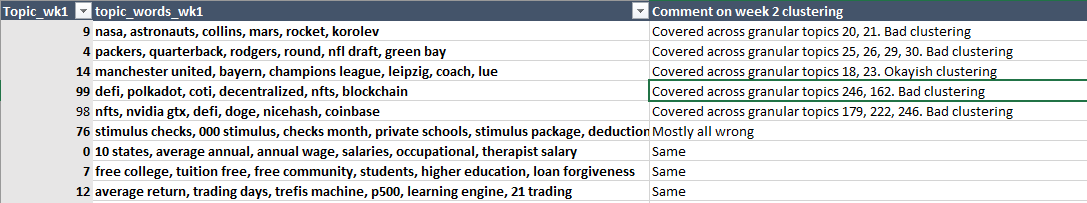

In [ ]:
# why this is happening - some authors just publish 1 article or very less. they might not belong to any specific topic. including more data (2week vs 1) might be pulling more of such articles
# essentially adding noise
# plus looks like the nature of algorithm creates disadvantage when smaller similar clusters are formed using more data points 

In [ ]:
# proposal - go ahead with 1 week, in future if better solutions for handling noise are found - include it in version 2

* **Week-over-week EDA**

In [70]:
week1_df = apr19_apr24.copy()
week1_art_emebds = apr19_apr24_art_embed
print(week1_df.shape)
print(len(week1_art_emebds))
print('Duplicates? ', week1_df.content_natid.duplicated(keep='first').any())

# concatenate week 2 dfs

week2_df = pd.concat([apr25, apr26, apr27, apr28, apr29, apr30, may01, may02])
# reset index
week2_df = week2_df.reset_index(drop=True)
# drop unnecessary cols
week2_df.drop(["processed", "processed_noun", "processed_noun_2"], axis = 1, inplace=True)
# fill na
week2_df.tier2 = week2_df.tier2.fillna('Other')
week2_df.total_timeonpage = week2_df.total_timeonpage.fillna(0)
print(week2_df.shape)

# concatenate embeds
week2_art_emebds = apr25_art_embed + apr26_art_embed + apr27_art_embed + apr28_art_embed + apr29_art_embed + apr30_art_embed + may01_art_embed + may02_art_embed
print(len(week2_art_emebds))

# drop duplicates from df

week2_df.drop_duplicates(subset="content_natid", keep='first', inplace=True)

print(week2_df.shape)
print(week2_df.content_natid.duplicated(keep='first').any())

week2_art_emebds =  [week2_art_emebds[i] for i in list(week2_df.index)]
print(len(week2_art_emebds))

print()
print(week1_df.shape)
print(week2_df.shape)

(7179, 11)
7179
Duplicates?  False
(30070, 9)
30070
(7506, 9)
False
7506

(7179, 11)
(7506, 9)


In [71]:
# almost half articles from week1 also read in week2
print('week1 read in week2', week1_df[week1_df.content_natid.isin(week2_df.content_natid)].shape)
print('week1 not read in week2', week1_df[~week1_df.content_natid.isin(week2_df.content_natid)].shape)

# almost half articles from week1 also read in week2
print('week2 read in past week1', week2_df[week2_df.content_natid.isin(week1_df.content_natid)].shape)
print('week2 not read in past week1',week2_df[~week2_df.content_natid.isin(week1_df.content_natid)].shape)

week1 read in week2 (4460, 11)
week1 not read in week2 (2719, 11)
week2 read in past week1 (4460, 9)
week2 not read in past week1 (3046, 9)


In [83]:
print('week-(t-1) in may03: ', week1_df[week1_df.content_natid.isin(may03.content_natid)].shape)
print('week-(t-1) in may04: ', week1_df[week1_df.content_natid.isin(may04.content_natid)].shape)
print('week-(t-1) in may05: ', week1_df[week1_df.content_natid.isin(may05.content_natid)].shape)
print('week-(t-1) in may06: ', week1_df[week1_df.content_natid.isin(may06.content_natid)].shape)
print('week-(t-1) in may07: ', week1_df[week1_df.content_natid.isin(may07.content_natid)].shape)

week-(t-1) in may03:  (2874, 11)
week-(t-1) in may04:  (2811, 11)
week-(t-1) in may05:  (2727, 11)
week-(t-1) in may06:  (2569, 11)
week-(t-1) in may07:  (2255, 11)


In [84]:
print('week-t in may03: ', week2_df[week2_df.content_natid.isin(may03.content_natid)].shape)
print('week-t in may04: ', week2_df[week2_df.content_natid.isin(may04.content_natid)].shape)
print('week-t in may05: ', week2_df[week2_df.content_natid.isin(may05.content_natid)].shape)
print('week-t in may06: ', week2_df[week2_df.content_natid.isin(may06.content_natid)].shape)
print('week-t in may07: ', week2_df[week2_df.content_natid.isin(may07.content_natid)].shape)

week-t in may03:  (3688, 9)
week-t in may04:  (3357, 9)
week-t in may05:  (3130, 9)
week-t in may06:  (2919, 9)
week-t in may07:  (2553, 9)
